In [1]:
!pip install timm torchvision tqdm kaggle --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.7 MB/s eta 0:00:00


In [2]:
from google.colab import files
import os
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d nickfratto/pacs-dataset
!unzip -q pacs-dataset.zip -d /content/pacs
!chmod -R 755 /content/pacs

Dataset URL: https://www.kaggle.com/datasets/nickfratto/pacs-dataset
License(s): unknown
 99% 522M/526M [00:14<00:00, 28.2MB/s]
100% 526M/526M [00:14<00:00, 38.2MB/s]


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from src import ViTWithAdapters
from torch.utils.data import ConcatDataset, DataLoader, Subset


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
import os
os.makedirs("results", exist_ok=True)

In [8]:

def load_model(checkpoint_path):

    model = ViTWithAdapters(num_domains=4, num_classes=7)

    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)


        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        elif isinstance(checkpoint, dict):
            model.load_state_dict(checkpoint, strict=False)
        else:
            model.load_state_dict(checkpoint)

    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        raise


    class_to_idx = checkpoint.get('class_to_idx', {}) if isinstance(checkpoint, dict) else {}

    return model.to(device).eval(), class_to_idx



In [9]:
model, class_to_idx = load_model("vit_adapters.pth")
print("Model loaded successfully")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-8-3bdc24b3b289>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model loaded successfully


In [10]:
def load_pacs_data(domain, subset_ratio=1.0, train_ratio=0.8):

    from torchvision import transforms, datasets
    from torch.utils.data import Subset, DataLoader, ConcatDataset

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(
        root=f'/content/pacs/pacs_data/pacs_data/{domain}',
        transform=transform
    )


    subset_size = int(len(full_dataset) * subset_ratio)
    indices = np.random.choice(len(full_dataset), subset_size, replace=False)
    subset = Subset(full_dataset, indices)


    train_size = int(train_ratio * len(subset))
    val_size = len(subset) - train_size
    return torch.utils.data.random_split(subset, [train_size, val_size])

In [12]:
def create_validation_loader(domains, subset_ratio=0.2):

    val_subsets = []

    for domain in domains:

        _, val_split = load_pacs_data(
            domain=domain,
            subset_ratio=subset_ratio,
            train_ratio=0.0
        )
        val_subsets.append(val_split)

    return DataLoader(
        ConcatDataset(val_subsets),
        batch_size=64,
        shuffle=False,
        num_workers=4 if torch.cuda.is_available() else 2
    )


In [13]:
DOMAINS = ['art_painting', 'cartoon', 'photo', 'sketch']

In [14]:
val_loader = create_validation_loader(
    domains=DOMAINS,
    subset_ratio=0.2
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    avg_loss = running_loss / len(loader)

    return avg_loss, accuracy, all_labels, all_preds

In [16]:
val_loss, val_acc, all_labels, all_preds = evaluate_model(model, val_loader)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.2f}%")

Evaluating: 100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


Validation Loss: 0.3847
Validation Accuracy: 87.58%


In [17]:
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('results/confusion_matrix.png')
    plt.show()

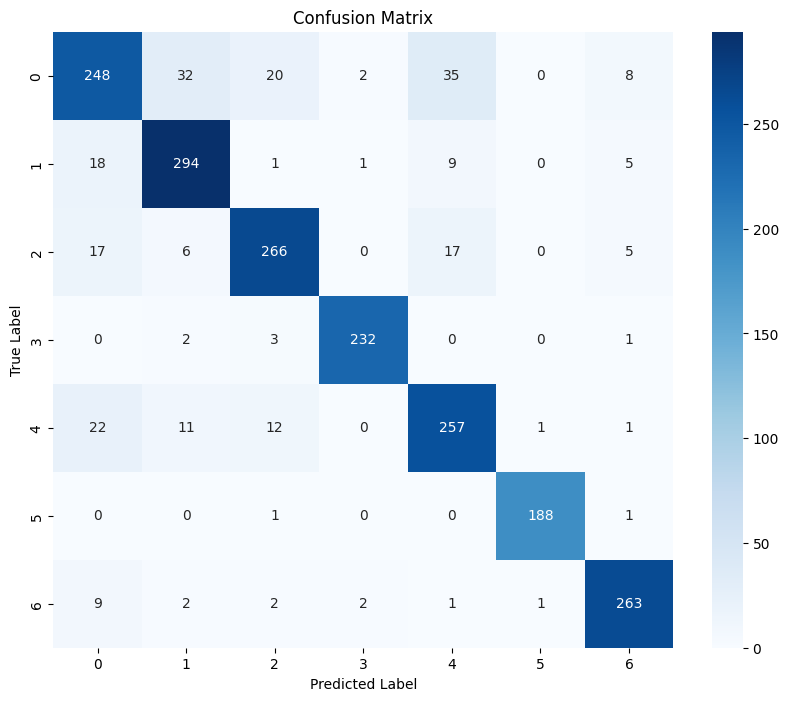

In [18]:
class_names = list(class_to_idx.keys()) if class_to_idx else [str(i) for i in range(7)]
plot_confusion_matrix(all_labels, all_preds, class_names)

In [19]:
def print_class_metrics(labels, preds, class_names):
    class_acc = {}
    for i in range(len(class_names)):
        idx = np.where(np.array(labels) == i)[0]
        correct = np.sum(np.array(preds)[idx] == i)
        class_acc[class_names[i]] = 100 * correct / len(idx) if len(idx) > 0 else 0

    print("\nClass-wise Accuracy:")
    for name, acc in class_acc.items():
        print(f"{name:15}: {acc:.2f}%")


In [20]:
print_class_metrics(all_labels, all_preds, class_names)


Class-wise Accuracy:
0              : 71.88%
1              : 89.63%
2              : 85.53%
3              : 97.48%
4              : 84.54%
5              : 98.95%
6              : 93.93%
